### Recommender system: Day in the city

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.mllib.recommendation import ALS
import sklearn
from sklearn.cluster import AgglomerativeClusteringAgglomerativeClustering
import requests
import time
%matplotlib inline

client_id = 'ua-7j9yr_CgcTD_4tQblcA'
api_key = '8dsXYq6nxsBx-XpawRnB6ONyWjpz-vpt0hkk7XGMSh2KfMuoH-KIN-yEow0MBFCuuP6gljF9qgFa58jXB9NuvpY52o6EiSgTX4yncXLPVbIGSaHQi1fBSAWySnJcXHYx'

def yelp_call(url_params, api_key):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer {}'.format(api_key)}
    response = requests.get(url, headers=headers, params=url_params)
    
    df = pd.DataFrame(response.json()['businesses'])
    return df

def all_results(url_params, api_key):
    num = response.json()['total']
    print('{} total matches found.'.format(num))
    cur = 0
    dfs = []
    while cur < num and cur < 1000:
        url_params['offset'] = cur
        dfs.append(yelp_call(url_params, api_key))
        time.sleep(1) #Wait a second
        cur += 50
    df = pd.concat(dfs, ignore_index=True)
    return df

term = 'pizza'
location = 'Astoria NY'
url_params = {  'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit' : 50
             }

df = all_results(url_params, api_key)
print(len(df))
df.head()

from itertools import combinations, permutations
from bs4 import BeautifulSoup

1. Web Scrape common names

page = f'https://www.ssa.gov/oact/babynames/decades/names2010s.html'

# Make a get request to retrieve the page
html_page = requests.get(page)

# Pass the page content to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 
pretty_soup = soup.prettify()

pretty_soup = pretty_soup.strip('').split('\n')

pretty_soup.index('         <th abbr="female number" style="text-align:right; background-color:white; color:black">')

pretty_soup = pretty_soup[226:]

a = ''.join(pretty_soup)
a = a.replace('</td>',"")
a = a.replace(' ',"")
a = a.split('<td>')

b = list(filter(lambda x: x.isalpha() , a))

b[:10]

page = f'https://www.yelp.com/user_details?userid=3TWGb7-IY3xjfgr2Htsy8w'

# Make a get request to retrieve the page
html_page = requests.get(page)

# Pass the page content to beautiful soup for parsing
soup1 = BeautifulSoup(html_page.content, 'html.parser') 
pretty_soup1 = soup1.prettify()

pretty_soup1.split('\n')

names = [''.join(p) for p in permutations('abc')]
names

### 2. EDA -  business.json

In [80]:
# reading in file
df = pd.read_json('business.json', lines = True) 
df.describe()

,is_open,latitude,longitude,review_count,stars
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000
mean,0.823040,38.541803,-97.594785,33.538962,3.585627
std,0.381635,4.941964,16.697725,110.135224,1.018458
min,0.000000,33.204642,-115.493471,3.000000,1.000000
25%,1.000000,33.637408,-112.274677,4.000000,3.000000
50%,1.000000,36.144815,-111.759323,9.000000,3.500000
75%,1.000000,43.602989,-79.983614,25.000000,4.500000
max,1.000000,51.299943,-72.911982,8348.000000,5.000000


In [81]:
# Dropping Canadian cities

df.postal_code = df.postal_code.apply(lambda x: x if len(x) == 5 else np.nan)

In [82]:
# Dropping Null Attributes column
df = df[~df['postal_code'].isnull()]  
df = df[~df['attributes'].isnull()]    

In [83]:
# Limiting low frequency cities to 500. Below is the list of cities to keep

keep_city = list(pd.DataFrame(df.groupby('city').filter(lambda x : len(x)>500)['city'].value_counts()).reset_index()['index'])
print('Cities to keep:', keep_city)
df.drop(df[~df.city.isin(keep_city)].index, inplace=True)

df.drop(df[df.is_open == 0].index, inplace = True) # dropping permanently closed businesses
df.drop(['is_open'], axis = 1, inplace = True) # dropping because are all open
df.head()


Cities to keep: ['Las Vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Pittsburgh', 'Mesa', 'Henderson', 'Tempe', 'Chandler', 'Madison', 'Cleveland', 'Glendale', 'Gilbert', 'Peoria', 'North Las Vegas', 'Champaign', 'Surprise', 'Concord', 'Goodyear', 'Matthews', 'Avondale', 'Huntersville', 'Fort Mill']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC
7,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",36.099872,-115.074574,Supercuts,89121,3,3.5,NV
11,2450 E Indian School Rd,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
16,"4848 E Cactus Rd, Ste 100","{'BusinessAcceptsCreditCards': 'True', 'Busine...",giC3pVVFxCRR89rApqklyw,"Hair Stylists, Beauty & Spas, Hair Salons, Men...",Scottsdale,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '...",33.600071,-111.977371,Knot Salon,85254,5,5.0,AZ


In [84]:
# Categories df

cat = pd.read_json('categories.json')

In [85]:
cat.head(2)

,alias,country_blacklist,country_whitelist,parents,title
0,3dprinting,NaN,NaN,[localservices],3D Printing
1,abruzzese,NaN,[IT],[italian],Abruzzese


In [86]:
df.categories = df.categories.apply(lambda x: x.replace(" ",""))

In [87]:
df.categories = df.categories.str.split(",")

In [88]:
df = df.reset_index().drop(['index'],axis = 1)

In [89]:
ls = []
for i in range(df.shape[0]):
    if df.categories[i] == None:
        ls.append(np.nan)
    else:
        x = str(cat.parents[cat.title == df.categories[i][0]])
        ls.append(x[x.index("[")+1:x.index("]")])
df["parents"] = ls

In [90]:
# Restaurants only
df_non_restaurants = df.drop(df[df.parents == 'restaurants'].index)
df = df.drop(df[df.parents != 'restaurants'].index)
df.head()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state,parents
9,"Center Core - Food Court, Fl 3, Pittsburgh Int...","{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1RHY4K3BD22FK7Cfftn8Mg,"[Sandwiches, Salad, Restaurants, Burgers, Comf...",Pittsburgh,None,40.496177,-80.246011,Marathon Diner,15231,35,4.0,PA,restaurants
11,6055 E Lake Mead Blvd,"{'BikeParking': 'True', 'BusinessParking': '{'...",tstimHoMcYbkSC4eBA1wEg,"[Mexican, Restaurants, Patisserie/CakeShop, Fo...",Las Vegas,"{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",36.195615,-115.040529,Maria's Mexican Restaurant & Bakery,89156,184,4.5,NV,restaurants
32,436 Market St,"{'OutdoorSeating': 'False', 'HasTV': 'True', '...",v-scZMU6jhnmV955RSzGJw,"[Japanese, SushiBars, Restaurants]",Pittsburgh,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",40.441062,-80.002126,No. 1 Sushi Sushi,15222,106,4.5,PA,restaurants
35,"13843 N Tatum Blvd, Ste 15","{'Caters': 'True', 'GoodForKids': 'True', 'Noi...",44YFU284Z3KDEy25QyVoUw,"[Chinese, Restaurants]",Phoenix,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",33.613020,-111.977036,Nee House Chinese Restaurant,85032,269,3.5,AZ,restaurants
69,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"[Seafood, Restaurants]",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ,restaurants


In [91]:
# Converting Attributes dictionary in dataframe

attributes_df = df.attributes.apply(pd.Series)
attributes_df = pd.concat([df, attributes_df], axis = 1)

#Dropping non-attribute columns
attributes_df = attributes_df.drop(['address', 'attributes','hours',
                                    'latitude', 'longitude', 'name', 'postal_code'], axis = 1)

In [92]:
#Cleaning Noise Level

ch = {"u'average'": "'average'","u'quiet'": "'quiet'","u'loud'": "'loud'","u'very_loud'": "'very_loud'"}
attributes_df.NoiseLevel = attributes_df.NoiseLevel.replace(to_replace = ch, value=None)

In [93]:
attributes_df.RestaurantsPriceRange2.value_counts()

1       2843
2       2430
3        154
4         34
None       4
Name: RestaurantsPriceRange2, dtype: int64

In [94]:
attributes_df[(attributes_df.review_count > 50) & (attributes_df.GoodForMeal.isnull() == True)].business_id.count()

145

In [95]:
attributes_df = attributes_df[attributes_df.GoodForMeal.isnull() == False]

In [96]:
attributes_df = attributes_df.reset_index().drop(['index'], axis = 1)

In [97]:
import ast

In [98]:
goodformeal_df = attributes_df.GoodForMeal.apply(ast.literal_eval)
goodformeal_df = goodformeal_df.apply(pd.Series)
goodformeal_df.head(2)

,dessert,latenight,lunch,dinner,brunch,breakfast
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0


In [99]:
attributes_df = pd.concat([attributes_df, goodformeal_df], axis = 1)

In [100]:
cat_df = attributes_df.categories.apply(lambda x: dict(zip(x, [True]*len(x)))).apply(pd.Series)

In [101]:
attributes_df = pd.concat([attributes_df, cat_df], axis = 1)

In [102]:
attributes_df.shape

(4440, 319)

In [103]:
#Categories to drop : low frequency < 5

cat_drop = []
for col in cat_df.columns:
    if cat_df[col].count() <=5:
        cat_drop.append(col)
len(cat_drop)

137

In [104]:
# Dropping from attributes df low frequency columns

for col in cat_drop:
    attributes_df.drop([col],axis =1, inplace=True)

In [105]:
attributes_df.shape

(4440, 182)

In [106]:
attributes_df = attributes_df[attributes_df.RestaurantsPriceRange2 != 'None']
attributes_df.drop(['categories'],axis = 1)

,business_id,city,review_count,stars,state,parents,RestaurantsTakeOut,BusinessParking,Ambience,RestaurantsDelivery,...,Kebab,HealthMarkets,HotPot,MusicVenues,Kosher,Live/RawFood,Afghan,African,Persian/Iranian,Smokehouse
0,1RHY4K3BD22FK7Cfftn8Mg,Pittsburgh,35,4.0,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tstimHoMcYbkSC4eBA1wEg,Las Vegas,184,4.5,NV,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v-scZMU6jhnmV955RSzGJw,Pittsburgh,106,4.5,PA,restaurants,True,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44YFU284Z3KDEy25QyVoUw,Phoenix,269,3.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nsNONDHbV7Vudqh21uicqw,Scottsdale,526,3.5,AZ,restaurants,False,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6fPQJq4f_yiq1NHn0fd11Q,Las Vegas,535,3.5,NV,restaurants,True,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,k-dDZvTeLysoJvjHI-qr9g,Las Vegas,287,3.0,NV,restaurants,False,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,F6c3D1o9Z4Tl6cDorb3WgA,Pittsburgh,75,3.5,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hXzoNgpkC86K_Jfg_zMHvA,Glendale,96,4.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AMN3Sgns9tB2x-b3eWk0qQ,Scottsdale,457,4.0,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
for col in attributes_df.columns:
    print(attributes_df[col].value_counts())

59YbAeuiz0isJtRNKATTKw    1
tKWoQENTGxhYCJSbY4ZLsQ    1
FqXwm6UpihHY7Ha-pr4y6Q    1
zXR-C_clfbCksI0cIDrl4g    1
v80Rx2UVjIkOhh0hg7lerw    1
5k8kyvvReTf1RMq4jpayQg    1
ePt0qmZgU-fjqMoM1M2U3Q    1
auB5N35tEmkczfiv915FbQ    1
GrJ74hxJsXXwcqS7zcfFhw    1
PRUtZy3DUl4sPOisYfOAuw    1
E6DmUAHfSRCEakvknot-zA    1
EVpjpTaSUdeXG0b69krzAQ    1
91VUQhU9fyV-usA7aeN6mA    1
xcjEnqXQU4a6FfomtQR9tQ    1
4GEDMStjXvSg-s4wacGRrw    1
OiutT-PHcZd6y2cEJ_yEVw    1
PAilv1TpsWMsLTZk5d3guw    1
1BvWaR-5EcODm59zRmNKkQ    1
tT5kEAq2DFTKqc6mJ9ptCg    1
xistlMeIIjG21z2SaWvfVQ    1
H-05-lRUJDUNDgYgaw7bXA    1
yZ0Ly75hbFx7M-9vDzrS4g    1
Scs-a2ybPdeT_mb7uZyLkQ    1
jrE4M9HlYp2AZZ7iQCSIRw    1
IQVka-wzJmN3jw2W70aCzw    1
R_U8YA_SVt_3z_f6_jEPtA    1
mB_cI1tCrNxxvr2e2myNrQ    1
z9lOfnUorcbWR_xS0DSeHw    1
EtZacHzJ2gw0V9Sdm2rLQA    1
gXLiBVCHIqoPEw2CaP3QmQ    1
                         ..
DA-ddRqcReCe_DcXKicvsQ    1
GMBvBDKgOT51xDTpGVphBw    1
I5TnTKHzJuLA0YLZPGCNwQ    1
4OUGSeQeASZGn9nSb8Ialg    1
uaVuq9mXAEOkopiFWIY8

Name: Turkish, dtype: int64
True    22
Name: Taiwanese, dtype: int64
True    9
Name: Peruvian, dtype: int64
True    18
Name: LocalFlavor, dtype: int64
True    10
Name: Waffles, dtype: int64
True    68
Name: Hawaiian, dtype: int64
True    30
Name: FoodTrucks, dtype: int64
True    86
Name: Southern, dtype: int64
True    12
Name: FoodStands, dtype: int64
True    11
Name: StreetVendors, dtype: int64
True    20
Name: Filipino, dtype: int64
True    17
Name: Spanish, dtype: int64
True    18
Name: TapasBars, dtype: int64
True    9
Name: DiveBars, dtype: int64
True    17
Name: Tapas/SmallPlates, dtype: int64
True    9
Name: Teppanyaki, dtype: int64
True    12
Name: Mongolian, dtype: int64
True    10
Name: NewMexicanCuisine, dtype: int64
True    31
Name: Wraps, dtype: int64
True    9
Name: Breweries, dtype: int64
True    9
Name: Irish, dtype: int64
True    7
Name: Brasseries, dtype: int64
True    7
Name: Cafeteria, dtype: int64
True    27
Name: SoulFood, dtype: int64
True    18
Name: BeerBar, dt

In [108]:
clean_df = attributes_df.drop(['categories','city','state','parents','RestaurantsTakeOut',
                   'RestaurantsDelivery','DriveThru','GoodForMeal','WiFi',
                   'Caters','RestaurantsTableService','BYOBCorkage','Corkage',
                   'BYOB','CoatCheck','Smoking','GoodForDancing','DogsAllowed',
                   'BusinessAcceptsBitcoin','ByAppointmentOnly','AgesAllowed',
                   'Open24Hours','DietaryRestrictions','RestaurantsCounterService',
                   'AcceptsInsurance','Music','BestNights', 'HappyHour'],axis = 1)

In [109]:
# Number of Ambience null values to drop
sum(clean_df.Ambience.isnull())

116

In [110]:
# Unpacking Ambience dictionary & dropping null values

clean_df = clean_df[clean_df.Ambience.isnull() == False]
ambience_df = clean_df.Ambience.apply(ast.literal_eval)
ambience_df = ambience_df.apply(pd.Series)
clean_df = pd.concat([clean_df, ambience_df], axis = 1)
clean_df.drop(['Ambience'],axis = 1,inplace = True)
clean_df.head(2)

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [111]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [112]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [113]:
# Unpacking Parking column - replacing null values by no street parking

parking_df = clean_df.BusinessParking.replace(to_replace = np.nan, value = "{'street':False}")
parking_df = parking_df.apply(ast.literal_eval)
parking_df = parking_df.apply(pd.Series)

In [114]:
# Assigning Boolean value to parking: True if garage, validated, lot, valet parking available; False otherwise.

parking_df['parking'] = parking_df['garage']|parking_df['validated']|parking_df['lot']|parking_df['valet']
parking_df.drop(['garage','street','validated','lot','valet'], axis = 1, inplace=True)
clean_df = pd.concat([clean_df, parking_df], axis = 1)
clean_df.drop(['BusinessParking'],axis = 1,inplace = True)

In [115]:
#Cleaning Restaurants Attire

attire = {"u'casual'": "'casual'","u'dressy'": "'dressy'","u'formal'":"'dressy'","'formal'":"'dressy'"}
clean_df.RestaurantsAttire = clean_df.RestaurantsAttire.replace(to_replace = attire, value=None)

In [116]:
#Cleaning Alcohol

alc = {"u'none'": "False","'none'": "False","None": "False","u'full_bar'": "True","'full_bar'": "True",
      "u'beer_and_wine'": "True","'beer_and_wine'":"True"}
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = alc, value=None)

In [117]:
clean_df.WheelchairAccessible.value_counts()

True     954
False     52
None       4
Name: WheelchairAccessible, dtype: int64

In [118]:
clean_df.head(3)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,parking
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,False,True,1,True,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,False,True,1,True,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True
2,v-scZMU6jhnmV955RSzGJw,106,4.5,False,True,2,False,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [119]:
# Filling NA values

clean_df.RestaurantsPriceRange2.fillna(1, inplace = True)
clean_df.RestaurantsPriceRange2.isna().sum()

0

In [120]:
clean_df.RestaurantsAttire.value_counts()

'casual'    4121
'dressy'      91
Name: RestaurantsAttire, dtype: int64

In [121]:
# Wheelchair access

wch = {False:0, True:1,'False':0, 'True':1,'None':0}
clean_df.WheelchairAccessible = clean_df.WheelchairAccessible.replace(to_replace = wch, value=None)
clean_df.GoodForKids = clean_df.GoodForKids.replace(to_replace = wch, value=None)
clean_df.HasTV = clean_df.HasTV.replace(to_replace = wch, value=None)
clean_df.OutdoorSeating = clean_df.OutdoorSeating.replace(to_replace = wch, value=None)
clean_df.BikeParking = clean_df.BikeParking.replace(to_replace = wch, value=None)
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = wch, value=None)
clean_df.BusinessAcceptsCreditCards = clean_df.BusinessAcceptsCreditCards.replace(to_replace = wch, value=None)
clean_df.RestaurantsReservations = clean_df.RestaurantsReservations.replace(to_replace = wch, value=None)
clean_df.RestaurantsGoodForGroups = clean_df.RestaurantsGoodForGroups.replace(to_replace = wch, value=None)

clean_df.RestaurantsAttire.fillna("'casual'", inplace = True)  

clean_df.NoiseLevel = clean_df.NoiseLevel.replace('None', value="'average'")
clean_df.NoiseLevel.fillna("'average'", inplace = True)  

clean_df.WheelchairAccessible.fillna(2, inplace = True)  # 2 means unknown
clean_df.fillna(0, inplace=True)
clean_df = clean_df.replace(to_replace = wch, value=None)

In [122]:
# change type
clean_df.RestaurantsPriceRange2 = clean_df.RestaurantsPriceRange2.astype(int)

In [123]:
clean_df = pd.concat([clean_df,pd.get_dummies(clean_df.NoiseLevel),pd.get_dummies(clean_df.RestaurantsAttire)],
                     axis = 1)
clean_df.drop(['NoiseLevel','RestaurantsAttire'], axis = 1, inplace = True)

In [124]:
clean_df.head(2)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,upscale,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy'
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,0.0,1.0,1,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1,1,0,0,0,1,0


### Part 2: Modeling

In [125]:
#!conda install -y -c conda-forge scikit-surprise
from surprise import SVD
from surprise.model_selection import cross_validate

In [126]:
X = clean_df.drop(['business_id'], axis = 1)

In [127]:
X.shape

(4322, 165)

#### Part 2 A: Clustering

In [128]:
from sklearn.cluster import KMeans # import from sklearn
from sklearn.metrics import calinski_harabaz_score

k_means = KMeans(n_clusters=10) # Must set number of clusters at initialization time!
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [135]:
preds = k_means.predict(X)

In [129]:
centers = k_means.cluster_centers_

In [130]:
pd.DataFrame(k_means.cluster_centers_, columns = X.columns)

,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,BikeParking,...,upscale,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy'
0,632.914474,3.963816,0.572368,0.980263,1.980263,0.986842,0.776316,0.657895,0.480263,0.723684,...,0.065789,0.092105,0.776316,0.894737,0.960526,0.026316,1.315789e-02,-2.255141e-17,0.934211,0.065789
1,127.034853,3.684540,0.347632,0.983914,1.604111,0.933870,0.912422,0.613047,0.445934,0.813226,...,0.022341,0.030384,0.893655,0.731903,0.789097,0.036640,1.706881e-01,3.574620e-03,0.978552,0.021448
2,2495.333333,3.944444,0.444444,1.000000,2.111111,0.777778,0.666667,0.555556,0.333333,0.444444,...,0.000000,0.111111,0.777778,0.777778,0.888889,0.111111,0.000000e+00,0.000000e+00,0.777778,0.222222
3,3676.800000,4.100000,0.600000,1.000000,2.200000,0.800000,0.600000,0.600000,0.200000,0.400000,...,0.200000,0.200000,0.600000,1.000000,0.800000,0.200000,0.000000e+00,0.000000e+00,0.800000,0.200000
4,1610.800000,4.133333,0.533333,1.000000,2.166667,0.966667,0.766667,0.566667,0.400000,0.633333,...,0.066667,0.066667,0.766667,0.766667,0.933333,0.033333,-5.551115e-17,3.333333e-02,0.900000,0.100000
5,41.744877,3.361680,0.167008,0.975922,1.361168,0.858094,0.929303,0.433402,0.319672,0.664447,...,0.003074,0.008709,0.543545,0.467725,0.724898,0.058914,1.926230e-01,2.356557e-02,0.993852,0.006148
6,408.128767,3.880822,0.523288,0.991781,1.882192,0.956164,0.852055,0.679452,0.561644,0.841096,...,0.024658,0.049315,0.857534,0.838356,0.931507,0.010959,5.753425e-02,1.561251e-17,0.964384,0.035616
7,6708.000000,3.500000,0.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000
8,1007.037975,4.025316,0.620253,0.987342,2.063291,0.974684,0.759494,0.632911,0.582278,0.683544,...,0.101266,0.113924,0.670886,0.898734,0.886076,0.088608,1.265823e-02,1.265823e-02,0.873418,0.126582
9,244.636066,3.818852,0.483607,0.991803,1.773770,0.955738,0.893443,0.644262,0.549180,0.854098,...,0.013115,0.040984,0.891803,0.806557,0.863934,0.016393,1.196721e-01,1.769418e-16,0.973770,0.026230


Optimal number of clusters

In [164]:
k_means_4 = KMeans(n_clusters=4).fit(X)
k_means_7 = KMeans(n_clusters=7).fit(X)
k_means_10 = KMeans(n_clusters=10).fit(X)
k_means_13 = KMeans(n_clusters=13).fit(X)
k_means_16 = KMeans(n_clusters=16).fit(X)
k_means_19 = KMeans(n_clusters=19).fit(X)
k_means_22 = KMeans(n_clusters=22).fit(X)
k_means_25 = KMeans(n_clusters=100).fit(X)

k_list = [k_means_4,k_means_7,k_means_10,k_means_13,k_means_16,k_means_19,k_means_22,k_means_25]

In [162]:
CH_score = []
for ls in k_list:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

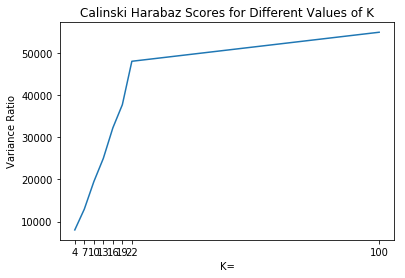

In [167]:
plt.plot([4,7,10,13,16,19,22,100], CH_score)
plt.xticks([4,7,10,13,16,19,22,100])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [174]:

k_means_5 = KMeans(n_clusters=5).fit(X)
k_means_50 = KMeans(n_clusters=50).fit(X)
k_means_100 = KMeans(n_clusters=100).fit(X)
k_means_150 = KMeans(n_clusters=150).fit(X)
k_means_200 = KMeans(n_clusters=200).fit(X)
k_means_120 = KMeans(n_clusters=120).fit(X)
k_means_130 = KMeans(n_clusters=130).fit(X)
k_means_140 = KMeans(n_clusters=140).fit(X)
k_means_150 = KMeans(n_clusters=150).fit(X)
k_means_160 = KMeans(n_clusters=160).fit(X)
k_means_170 = KMeans(n_clusters=170).fit(X)
k_means_180 = KMeans(n_clusters=180).fit(X)
k_means_190 = KMeans(n_clusters=190).fit(X)


k_list = [k_means_16,k_means_19,k_means_22,k_means_25,k_means_30]


CH_score = []
for ls in k_list:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))


In [176]:
k_list2 = [k_means_120, 
k_means_130 ,
k_means_140 ,
k_means_150 ,
k_means_160 ,
k_means_170 ,
k_means_180 ,
k_means_190 ]

CH_score = []
for ls in k_list2:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

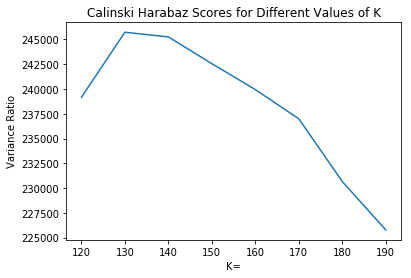

In [177]:
plt.plot([120,130,140,150,160,170,180,190], CH_score)
plt.xticks([120,130,140,150,160,170,180,190])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

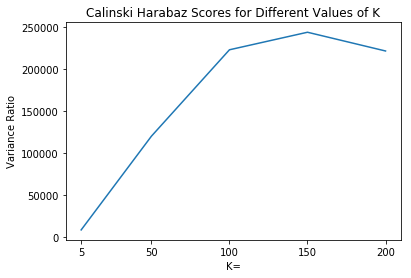

In [172]:
plt.plot([5,50,100,150,200], CH_score)
plt.xticks([5,50,100,150,200])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [182]:
k_means_130 = KMeans(n_clusters=130, init= 'random').fit_predict(X)

In [183]:

X_and_Y = pd.concat([X, pd.Series(k_means_130)],axis = 1)
X_and_Y.rename(columns={0:'pred'}, inplace=True)

In [188]:

# k_means_5 = KMeans(n_clusters=5, init = 'random').fit(X)
# k_means_50 = KMeans(n_clusters=50, init = 'random').fit(X)
# k_means_100 = KMeans(n_clusters=100, init = 'random').fit(X)
# k_means_150 = KMeans(n_clusters=150, init = 'random').fit(X)
# k_means_200 = KMeans(n_clusters=200, init = 'random').fit(X)
# k_means_120 = KMeans(n_clusters=120, init = 'random').fit(X)
# k_means_130 = KMeans(n_clusters=130, init = 'random').fit(X)
# k_means_140 = KMeans(n_clusters=140, init = 'random').fit(X)
# k_means_150 = KMeans(n_clusters=150, init = 'random').fit(X)
# k_means_160 = KMeans(n_clusters=160, init = 'random').fit(X)
# k_means_170 = KMeans(n_clusters=170, init = 'random').fit(X)
# k_means_180 = KMeans(n_clusters=180, init = 'random').fit(X)
# k_means_190 = KMeans(n_clusters=190, init = 'random').fit(X)

k_list2 = [k_means_120, 
k_means_130 ,
k_means_140 ,
k_means_150 ,
k_means_160 ,
k_means_170 ,
k_means_180 ,
k_means_190 ]

CH_score = []
for ls in k_list2:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

Calinski Harabaz Score : The higher VRC values point out the most appropriate number of clusters; it appraises both the distance between different clusters, as well as the closeness of data within each of those clusters (Cali´nskiCali´nski and Harabasz, 1974)

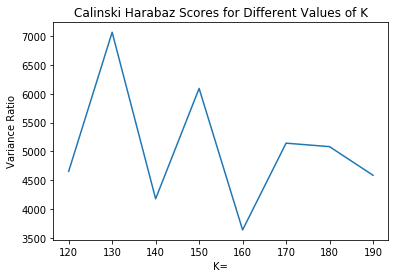

In [189]:
plt.plot([120,130,140,150,160,170,180,190], CH_score)
plt.xticks([120,130,140,150,160,170,180,190])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

Agglomerative clustering

In [221]:
def agg_cluster(X, n_list):
    klist = []
    preds_list = []
    for n in n_list:
        agg = AgglomerativeClustering(n_clusters = n, affinity= 'euclidean', linkage = 'ward')
        preds_list.append(agg.fit_predict(X))
        klist.append(agg.fit(X))
    return klist, preds_list

In [223]:
k_list, agg_preds= agg_cluster(X, [5,10,50,100])

In [226]:
def calinski_plot(X, n_list, model):
    k_list, preds_list = agg_cluster(X, n_list)
    CH_score = []
    for ls in k_list:
        labels = ls.labels_
        CH_score.append(calinski_harabaz_score(X,labels))

    plt.plot(n_list, CH_score)
    plt.xticks(n_list)
    plt.title("Calinski Harabaz Scores for Different Values of K")
    plt.ylabel("Variance Ratio")
    plt.xlabel("K=")
    plt.show()

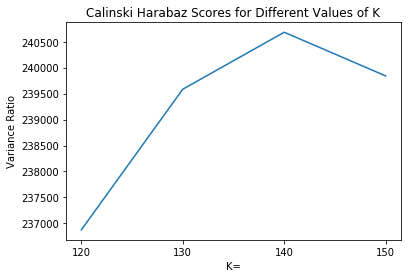

In [231]:
calinski_plot(X, [120,130, 140, 150])

In [232]:
_, preds = agg_cluster(X, [140])

In [239]:
def concat_preds(X, preds): 
    X_and_Y = pd.concat([X, pd.Series(preds[0])],axis = 1)
    X_and_Y.rename(columns={0:'pred'}, inplace=True)
    return X_and_Y

In [240]:
X_and_Y = concat_preds(X, preds)

In [241]:
X_and_Y.head()

,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,BikeParking,...,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy',pred
0,35.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
1,184.0,4.5,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,12.0
2,106.0,4.5,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0
3,269.0,3.5,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
4,526.0,3.5,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,74.0


In [281]:
from sklearn.mixture import GaussianMixture
 
gmm = GaussianMixture(n_components=100)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [283]:
gmm_preds = gmm.predict(X)

In [285]:
gmm_preds

array([1, 1, 1, ..., 0, 0, 1])

In [290]:
def calinski_plot(X, n_list):
    
    CH_score = []
    
    for n in n_list:
        gmm = GaussianMixture(n_components = n)
        gmm_preds = gmm.fit_predict(X)
        CH_score.append(calinski_harabaz_score(X,gmm_preds))

    plt.plot(n_list, CH_score)
    plt.xticks(n_list)
    plt.title("Calinski Harabaz Scores for Different Values of Components")
    plt.ylabel("Variance Ratio")
    plt.xlabel("Number of components=")
    plt.show()

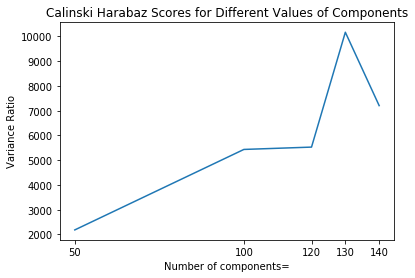

In [291]:
calinski_plot(X, [50,100,120,130,140])

In [296]:
from sklearn.metrics import silhouette_score, pairwise_distances

In [295]:
silhouette_score(X, gmm_preds, metric= '')

0.03197309670851649

In [309]:
similarity_matrix = pd.DataFrame(pairwise_distances(X, metric='cosine'))
similarity_matrix.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321
0,0.000000,0.008589,0.006831,0.009925,0.011088,0.011104,0.010503,0.004733,0.006062,0.010779,...,0.011046,0.006746,0.009180,0.004523,0.007481,0.011102,0.011106,0.011265,0.008398,0.007868
1,0.008589,0.000000,0.000531,0.000179,0.000361,0.000369,0.000255,0.001255,0.000752,0.000286,...,0.000335,0.010077,0.011976,0.010835,0.000416,0.000347,0.000363,0.000388,0.000220,0.000297


https://datascience.stackexchange.com/questions/8681/clustering-for-mixed-numeric-and-nominal-discrete-data

In [324]:
similarity_matrix.iloc[0].sort_values()

0       0.000000
2317    0.002047
628     0.002073
2819    0.002107
3991    0.002361
1582    0.002397
338     0.002446
3380    0.002589
2798    0.002636
653     0.002711
1895    0.002724
1365    0.002737
2677    0.002748
4309    0.002783
1545    0.002793
3678    0.002830
3377    0.002889
3149    0.002890
2210    0.002897
453     0.002912
948     0.002924
1398    0.002955
3805    0.002992
2023    0.002998
2405    0.003071
3759    0.003072
771     0.003089
2326    0.003108
1742    0.003117
1422    0.003132
          ...   
2055    0.245048
2502    0.253155
3396    0.264164
4097    0.270374
2663    0.270599
1314    0.274788
2799    0.279032
3274    0.279495
284     0.279495
2698    0.281603
194     0.286115
352     0.297550
2362    0.305227
542     0.308283
2319    0.308836
1869    0.312658
2951    0.315783
1863    0.343395
2849    0.346830
2399    0.351314
2248    0.359041
260     0.361450
3933    0.363860
1974    0.368159
4021    0.373947
2871    0.377417
1192    0.386923
1969    0.4003

In [326]:
X_and_Y[X_and_Y.pred == 47.0]

,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,BikeParking,...,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy',pred
0,35.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
45,34.0,3.5,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
141,17.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
154,205.0,4.5,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
175,16.0,2.5,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
192,60.0,3.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,47.0
208,42.0,4.5,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0
326,92.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,47.0
334,149.0,2.5,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0


In [319]:
sorted(list(similarity_matrix.iloc[0]))[1:11]

[0.002046917224833966,
 0.002072764388307169,
 0.002106729473709379,
 0.0023614617470884003,
 0.0023967302541847424,
 0.0024464906922481156,
 0.0025885672788166225,
 0.0026360271222969356,
 0.0027114369861074294,
 0.0027240168449215174]

In [337]:
from sklearn.neighbors import DistanceMetric

In [338]:
def gower_distance(X):
    individual_variable_distances = []
    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)